# Let's train a classifier

Stolen from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [102]:
import torch
import torchvision
import torchvision.transforms as transforms

In [103]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


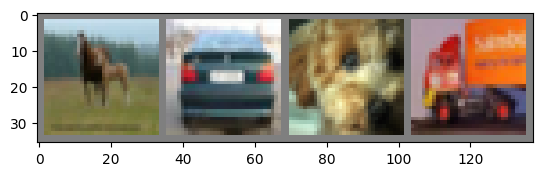

horse car   dog   truck


In [104]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [105]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [106]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [108]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.161
[1,  4000] loss: 1.814
[1,  6000] loss: 1.668
[1,  8000] loss: 1.591
[1, 10000] loss: 1.520
[1, 12000] loss: 1.471
[2,  2000] loss: 1.396
[2,  4000] loss: 1.386
[2,  6000] loss: 1.338
[2,  8000] loss: 1.353
[2, 10000] loss: 1.293
[2, 12000] loss: 1.278
Finished Training


In [109]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


### Let's replace Linear layer with a Conv2d layer. Just for fun. 

#### We'll see how  the weights are working and see that it's no big deal to operate them as usual data

In [115]:
net.fc1.weight.data.shape, net.fc1.weight.data.std()

(torch.Size([120, 400]), tensor(0.0426))

In [117]:
class Net_with_conv_instead_of_lin(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Conv2d(16 * 5 * 5, 120, kernel_size=(1,1))
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], np.prod(x.shape[1:]), 1, 1)
        x = F.relu(self.fc1(x))
        x = x.squeeze(-1).squeeze(-1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net2 = Net_with_conv_instead_of_lin()
state_dict_prev = net.state_dict()
state_dict2 = net2.state_dict()
print(state_dict_prev.keys())
for key in state_dict_prev:
    if key != 'fc1.weight':
        state_dict2[key] = state_dict_prev[key]
    else:
        print(state_dict2[key].shape, state_dict_prev[key].shape)
        state_dict2[key][:, :, 0, 0] = state_dict_prev[key]
net2.load_state_dict(state_dict2)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
torch.Size([120, 400, 1, 1]) torch.Size([120, 400])


<All keys matched successfully>

In [118]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


### What about the inference time? Is there any difference between backends?

In [119]:
import time
t0 = time.time()
for _ in range(100):
    net2(images)
print("Conv model", (time.time() - t0) / 100)
t0 = time.time()
for _ in range(100):
    net(images)
print("Linear model", (time.time() - t0) / 100)

Conv model 0.007206981182098389
Linear model 0.0005179286003112793


Yep, there is a difference between backends, which depends on the device, input shapes, etc. 

Iterating over equivalent operations can speed up the network without the need to retrain it (e.g., see https://cs.stanford.edu/~padon/taso-sosp19.pdf).

## Let's compile this model!

In [120]:
# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
input_names = ["actual_input_1"]
output_names = [ "output1" ]
dummy_input = torch.zeros_like(images)
torch.onnx.export(net, dummy_input, "some_net.onnx", input_names=input_names, output_names=output_names)

In [122]:
!ls -al ./some_net.onnx

-rw-r--r-- 1 ashilov2 domain users 249160 Dec  2 16:37 ./some_net.onnx


We received an .onnx file. Such representations can be much easier embedded in any programming language on any device, than a PyTorch model. 

They usually don't have PyTorch on the smart fridges.

In [123]:
import onnxruntime

In [124]:
t0 = time.time()
for _ in range(100):
    with torch.no_grad():
        net(images)
print("PyTorch latency", (time.time() - t0) / 100)

ort_sess = onnxruntime.InferenceSession('some_net.onnx')
images_np = images.numpy()
t0 = time.time()
for _ in range(100):
    outputs = ort_sess.run(None, {'actual_input_1': images_np})
print("Onnxruntime latency", (time.time() - t0) / 100)

PyTorch latency 0.0006494307518005371
Onnxruntime latency 0.00019600391387939454


We have just received an x2.5 inference speed up by selecting an appropriate runtime.

There are several runtimes which you might wanna try when speeding up the model, e.g. TVM https://tvm.apache.org/ . Each framework has its own set of the optimization techniques and might provide a different result.

For Nvidia, you might wanna use TensorRT https://github.com/NVIDIA/TensorRT

## Quantization concept

A C++ person might tell you that you're better use float64 when coding because the compilers are optimized for this precision.

This is not true in neural networks. A standart scenario is to train the model in float32, inference in float16, optionally apply quantization and convert to int8 with some accuracy drop. You might wanna retrain the model to be robust to quantization noises and to apply some sophisticated scalings to use it with int8. 

In [125]:
resnet = torchvision.models.resnet50()

In [126]:
images = images.cpu().double()
resnet = resnet.cpu().double()
t0 = time.time()
for _ in range(100):
    with torch.no_grad():
        resnet(images)
print("Double precision", (time.time() - t0) / 100)
images = images.float()
resnet = resnet.float()
t0 = time.time()
for _ in range(100):
    with torch.no_grad():
        resnet(images)
print("Float precision", (time.time() - t0) / 100)

Double precision 0.03352153301239014
Float precision 0.015976061820983888


In [127]:
images = images.cuda().float()
resnet = resnet.cuda().float()
for _ in range(100):
    with torch.no_grad():
        resnet(images)

t0 = time.time()
for _ in range(100):
    with torch.no_grad():
        resnet(images)
print("Float precision (cuda)", (time.time() - t0) / 100)
images = images.half()
resnet = resnet.half()
for _ in range(100):
    with torch.no_grad():
        resnet(images)

t0 = time.time()
for _ in range(100):
    with torch.no_grad():
        resnet(images)
print("Half precision (cuda)", (time.time() - t0) / 100)

Float precision (cuda) 0.008371152877807618
Half precision (cuda) 0.00621751070022583


The half result is not always stable here because we do not use a runtime, so the quantization speedup does not work with random model. However, it does provide a speedup inside a runtime more often.